In [7]:
#####################################################################
# Importing Packages
#####################################################################
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy import signal
import matplotlib.pylab as plt
import matplotlib.colors as colors
from daskms import xds_from_table, xds_to_table
from dask.distributed import Client
import ephem
import math

client = Client(n_workers=4, 
                threads_per_worker=4, 
                processes=True, 
                memory_limit='8GB'
                )
client

/home/kirsten/miniconda3/envs/daskms/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41783 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41783/status,
Dashboard: http://127.0.0.1:41783/status,Workers: 4
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44271,Workers: 4
Dashboard: http://127.0.0.1:41783/status,Total threads: 16
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:45451,Total threads: 4
Dashboard: http://127.0.0.1:46871/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:33157,


In [8]:
# Setting up matplotlib parameters
params = {'legend.fontsize': '18',
          'figure.figsize': (12, 10),
         'axes.labelsize': 18,
         'axes.titlesize':20,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'axes.labelweight':'bold',
         'font.size':18,
         'figure.max_open_warning': 0}
plt.rcParams.update(params)

In [9]:
#####################################################################
# Functions
#####################################################################
def compute_pairwise_distances_manual(coords):
    """
    Compute the Euclidean distance between each pair of objects given their coordinates
    and save the results in a numpy array.
    
    Parameters:
        coords (numpy.ndarray): A 2D array with shape (50, 3) where each row is an object and
                                columns represent x, y, and z coordinates respectively.
    
    Returns:
        numpy.ndarray: A 2D array where each row contains [Object 1, Object 2, Distance]
                       representing the pairwise distances between all objects.
    """
    num_objects = coords.shape[0]
    distances = []

    # Loop over each unique pair of objects
    for i in range(num_objects):
        for j in range(i + 1, num_objects):
            # Manually compute the Euclidean distance
            dx = coords[i][0] - coords[j][0]  # Difference in x coordinates
            dy = coords[i][1] - coords[j][1]  # Difference in y coordinates
            dz = coords[i][2] - coords[j][2]  # Difference in z coordinates
            distance = np.sqrt(dx**2 + dy**2 + dz**2)  # Euclidean distance formula
            distances.append([i, j, dx, dy, dz, distance])
    
    # Convert the list to a numpy array
    distances_array = np.array(distances)
    return distances_array

# Gaussian Function
def gauss(x, dc, a, x0, sigma):
    """
    This will fit a gaussian function to a data set
    """
    y = dc + a * (np.exp(-(((x - x0)**2) / (2 * sigma**2))))
    return y

def freq_to_channel(x):
    return ((x - 856) / (1711 - 856)) * 1024

def channel_to_freq(x):
    return ((x / 1024) * (1711 - 856)) + 856

In [10]:
#####################################################################
# Importing Data
#####################################################################
data_path = '/home/kirsten/Desktop/OT2/A02/1548939342.ms'
# Create xarray dataset
ds = xds_from_table(data_path)
spectral_table = xds_from_table(data_path+'::SPECTRAL_WINDOW')
antenna_table = xds_from_table(data_path+'::ANTENNA')

In [ ]:
#####################################################################
# Exploring Data
#####################################################################
print(ds)
# Finding Basic Antenna Information
A1 = ds[0]["ANTENNA1"]
A2 = ds[0]["ANTENNA2"]
ant_list = list(set(np.append(A1,A2)))
nants = len(ant_list)
inter = ds[0]["INTERVAL"]
print(f'Total number of antennas used {nants}')
print('Interval Table Shape: ',inter.shape)
print(f'Dump rate is {np.median(inter)} s')

In [ ]:
# Finding DATA_DESCRIPTION Information
data_desc_table = xds_from_table(data_path+'::DATA_DESCRIPTION')
print("\nData Description Info \nXXXXXXXXXXXXXXXXXXXXXXXXX")
for key in data_desc_table[0].keys():
    print(f'{key}: {data_desc_table[0][key].values}')

In [ ]:
# Finding FEED Information
feed_table = xds_from_table(data_path+'::FEED')
print("\nFeed Info \nXXXXXXXXXXXXXXXXXXXX")
for key in feed_table[0].keys():
    print(f'{key}: {feed_table[0][key].values}')

In [ ]:
# Finding POLARIZATION Information
polar_table = xds_from_table(data_path+'::POLARIZATION')
print("\nPolarization Info\nXXXXXXXXXXXXXXXXXX")
for key in polar_table[0].keys():
    print(f'{key}: {polar_table[0][key].values}')

In [ ]:
# Finding STATE Information
state_table = xds_from_table(data_path+'::STATE')
print("State Info\nXXXXXXXXXXXXXXXXXX")
for key in state_table[0].keys():
    print(f'{key}: {state_table[0][key].values}')

In [ ]:
# Finding Observation Information
obs_table = xds_from_table(data_path+'::OBSERVATION')
print("Observation Info \nXXXXXXXXXXXXXXXXXXX")
for key in obs_table[0].keys():
    print(f'{key}: {obs_table[0][key].values}')

In [ ]:
# Finding FIELD Information
field_table = xds_from_table(data_path+'::FIELD')
print("Field Info \nXXXXXXXXXXXXXXXXXXXXX")
for key in field_table[0].keys():
    print(f'{key}: {field_table[0][key].values}')

In [ ]:
# Finding SOURCE Information
source_table = xds_from_table(data_path+'::SOURCE')
print("Source Info\nXXXXXXXXXXXXXXXXXX")
for key in source_table[0].keys():
    print(f'{key}: {source_table[0][key].values}')

In [ ]:
# Finding SPECTRAL Information
spectral_table = xds_from_table(data_path+'::SPECTRAL_WINDOW')
print(spectral_table)
for key in spectral_table[0].keys():
    print(f'{key}: {spectral_table[0][key].values}')
frequencies   = spectral_table[0]['CHAN_FREQ'].values
nchannels     = spectral_table[0]['NUM_CHAN'].values[0]
channel_width = spectral_table[0]['CHAN_WIDTH'].values[0][0]

summary = {
    'Frequencies': frequencies,
    'No_Channeles': nchannels,
    'Channel_Width': channel_width,
    }
print(f"Frequency range (MHz): {summary['Frequencies'].min()/1.e6} - {summary['Frequencies'].max()/1.e6}")  
print(f"Total no of channles {summary['No_Channeles']}")
print(f"Channel width (kHz): {channel_width/1.e3}")

In [ ]:
# Finding Antenna Information
antenna_table = xds_from_table(data_path+'::ANTENNA')
print(antenna_table)
print(antenna_table[0]['NAME'].values)
print(antenna_table[0]['DISH_DIAMETER'].values)
print(antenna_table[0]['POSITION'].values)

# Baseline Analysis

In [11]:
#####################################################################
# Baseline Distances
#####################################################################
ant_positions = antenna_table[0]['POSITION'].values
dist = compute_pairwise_distances_manual(ant_positions)
print('Short Baseline: ', dist[1,5], 'Long Baseline: ', dist[1167,5])

Short Baseline:  29.25652099934559 Long Baseline:  7697.5799825164495


In [12]:
#####################################################################
# UVW Analysis
#####################################################################
# Get the UVW points
u,v,w = ds[0]['UVW'][:,0],ds[0]['UVW'][:,1],ds[0]['UVW'][:,2]

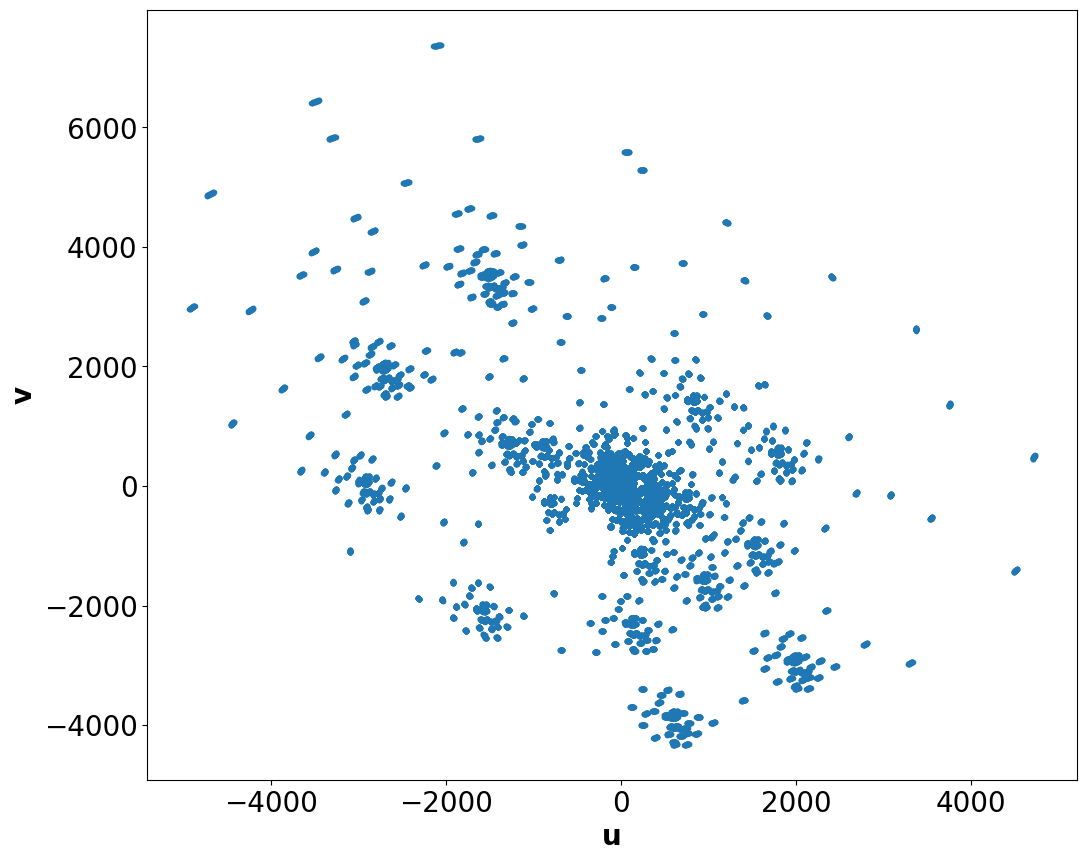

In [13]:
# Plotting the UV coverage
plt.plot(u,v,'.')
plt.xlabel('u', fontsize=20)
plt.ylabel('v', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize = 20)
plt.show()

In [14]:
#####################################################################
# XYZ Analysis
#####################################################################
X,Y,Z = antenna_table[0]['POSITION'][:,0],antenna_table[0]['POSITION'][:,1],antenna_table[0]['POSITION'][:,2]

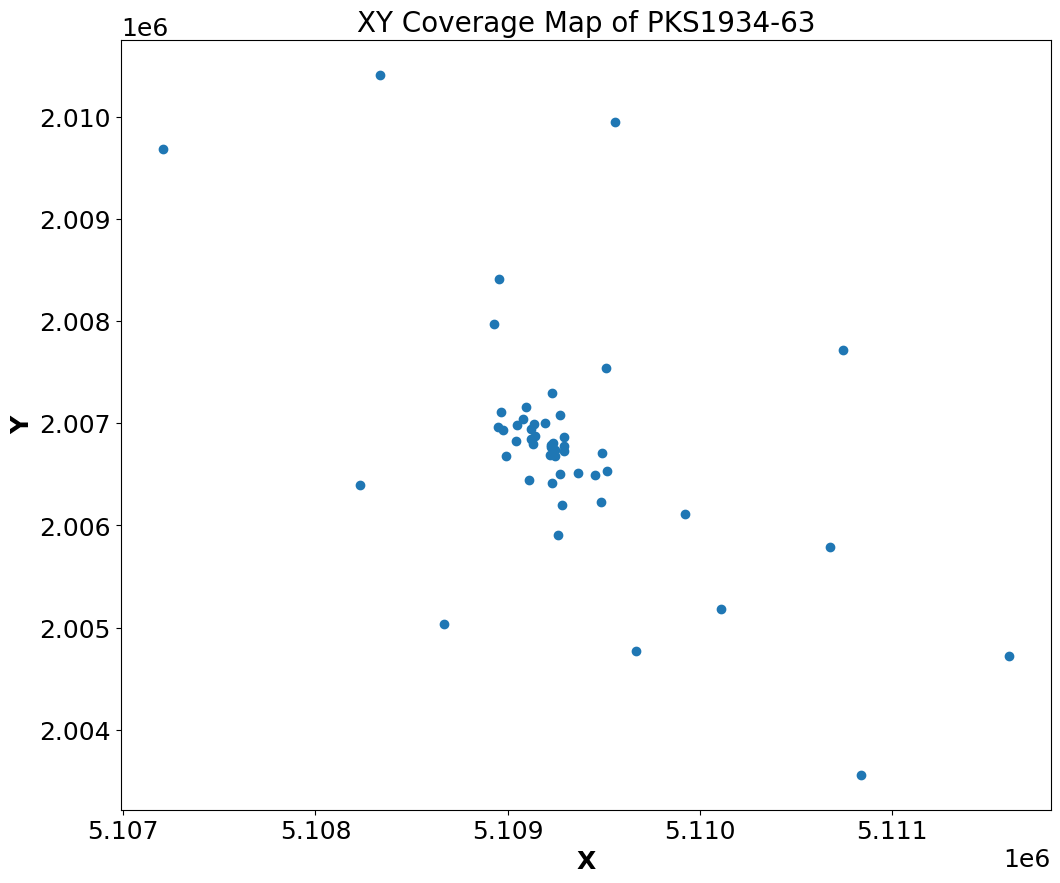

In [15]:
# Plotting the XY coverage
plt.plot(X,Y, 'o')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('XY Coverage Map of PKS1934-63')
plt.show()

# Visibility Analysis

In [16]:
#####################################################################
# Visibility Analysis
#####################################################################
vis = ds[0]['DATA']
vis.shape

(31875, 1024, 2)

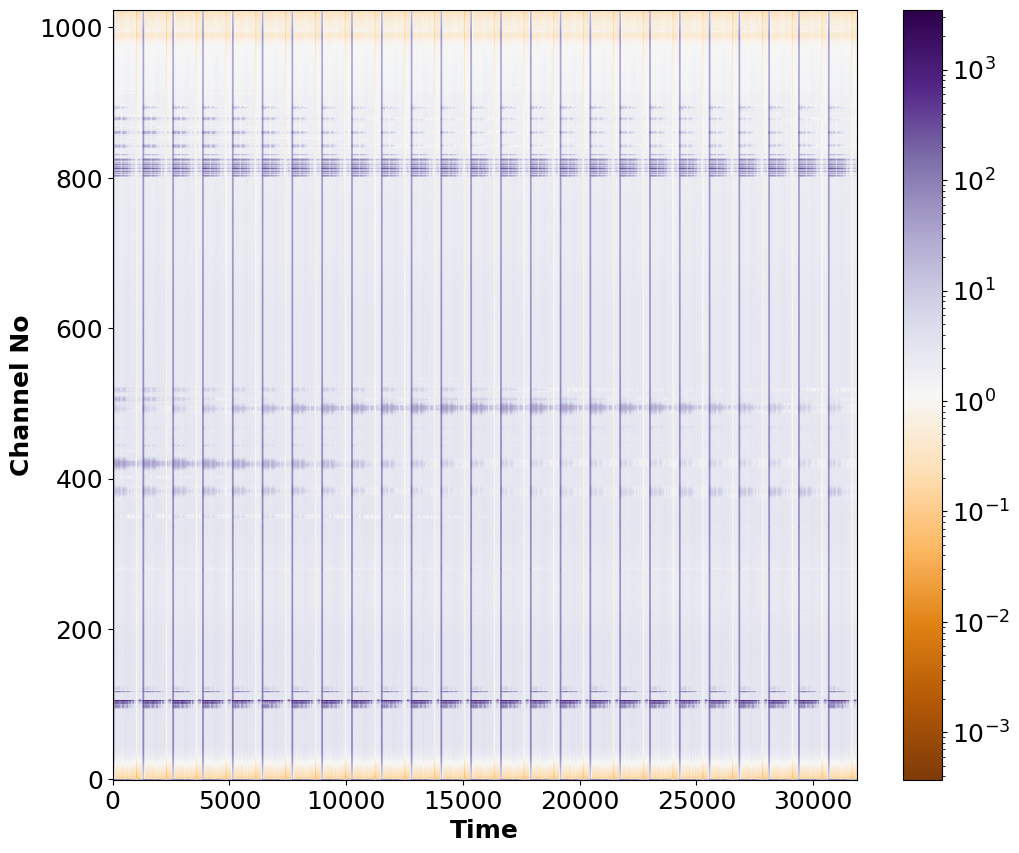

In [17]:
# Plotting the visibility in 0
plt.imshow(np.abs(vis[:,:,0]).T, 
           aspect= 'auto', 
           origin='lower', 
           cmap='PuOr', 
           norm = colors.LogNorm()
           )
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()
plt.show()

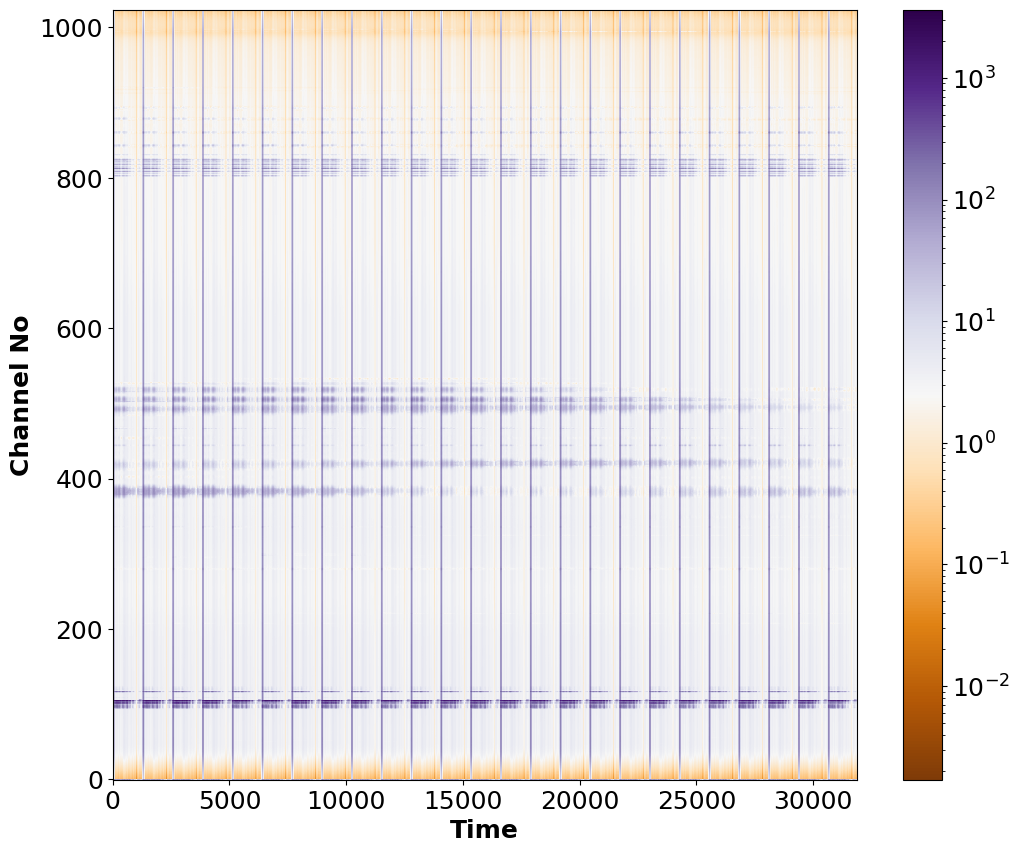

In [18]:
# Plotting the visibility in 1
plt.imshow(np.abs(vis[:,:,1]).T, 
           aspect= 'auto', 
           origin='lower', 
           cmap='PuOr', 
           norm = colors.LogNorm()
           )
plt.ylabel('Channel No')
plt.xlabel('Time')
plt.colorbar()
plt.show()

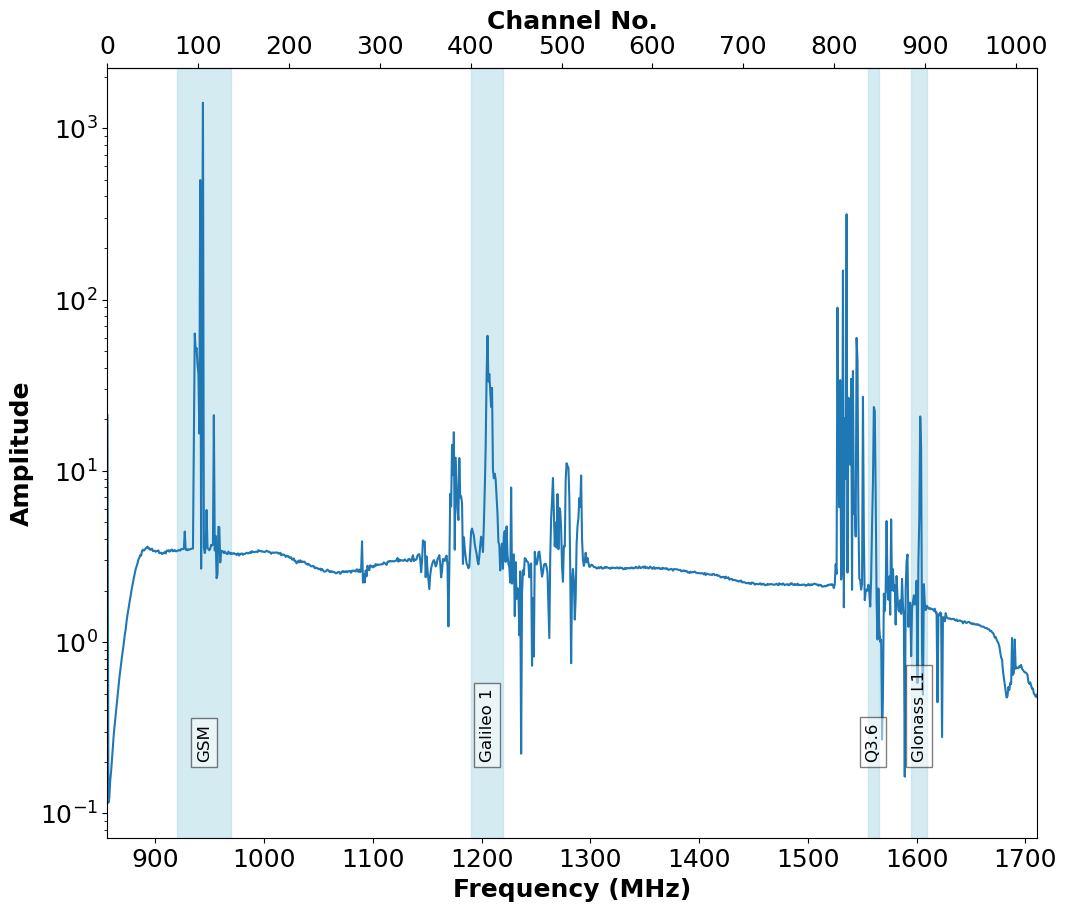

In [19]:
# Doing a 1-D cut across the visibility 
subset = vis[500,:,0].compute()
frequencies = spectral_table[0]['CHAN_FREQ'].values.T

RFI_regions = [
    (920, 970, 'GSM'),  # (start, end, label)
    (1190, 1220, 'Galileo 1'),
    (1595, 1610, 'Glonass L1'),
    (1555, 1565, 'Q3.6')
]

fig1, ax1 = plt.subplots(1,1)

ax1.plot(frequencies/1e6, np.abs(subset))
ax1.semilogy()
ax1.set_xlim(frequencies[0]/1e6, frequencies[-1]/1e6)

# Highlight the specified regions
for start, end, label in RFI_regions:
    ax1.axvspan(start, end, color='lightblue', alpha=0.5)
    ax1.text((start + end) / 2, 0.2, label, 
             horizontalalignment='center', verticalalignment='bottom', rotation='vertical',
             fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Frequency (MHz)')

secax = ax1.secondary_xaxis('top', functions=(freq_to_channel, channel_to_freq))
secax.set_xticks(np.arange(0, 1024, 100))  # Ticks from 0 to 1024 in steps of 100
secax.set_xlabel('Channel No.')
plt.show()

In [20]:
# Contaminated Region
# 400-440 (1190-1223)
# Clean Region
# 730-770 (1466, 1499)
# Interesting RFI
# 835-855 (1561)

ini_idx = 835
fin_idx = 855

x = np.ravel(frequencies[ini_idx:fin_idx])
y = np.log10(np.abs(subset[ini_idx:fin_idx]))

# weighted arithmetic mean (corrected)
mean = (sum(x * y) / sum(y)).values
sigma = (np.sqrt(sum(y * (x - mean)**2) / sum(y))).values
dc = np.nanmean(np.log10(np.abs(subset[650:750])).values)-1
y_max = y.max()
ini_guess = np.array([dc, y_max, mean, sigma])

popt, pcov = curve_fit(gauss, x, y, p0=ini_guess)
print(popt)

[8.62962720e-02 1.31002887e+00 1.56088459e+09 1.36096092e+06]


/tmp/ipykernel_25442/2592188369.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx],15)


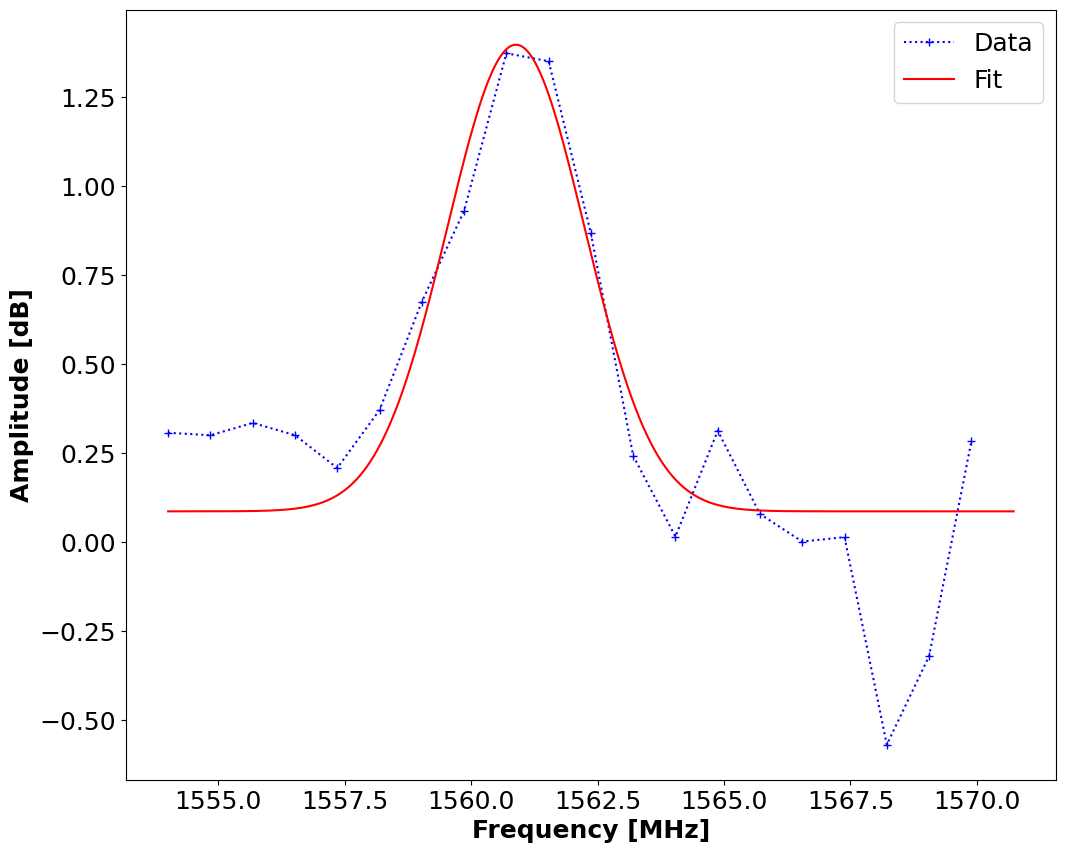

In [21]:
plt.plot(x/1e6, y, 'b+:', label='Data')
x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx],15)
plt.plot(x_new/1e6, gauss(x_new, *popt), 'r-', label='Fit')
plt.legend()

#plt.ylim(0, 3)
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.show()

In [22]:
gauss_contam = gauss(x_new, *popt)
print (f"FWHM [MHz] =  {(2.*np.sqrt(2.*np.log(2.))*sigma)/1.e6}")
print(f"Maximum amplitude is at [db], {max(gauss_contam)} ")
print (f"Maximum is at [MHz]  {x_new[np.argmax(gauss_contam)]/1.e6}")
print(f"Number of channels affected {int((2. * np.sqrt(2. * np.log(2.)) * sigma) / channel_width)}")
print('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
print('Statistical Moments of the Gaussian Fit')
print(f'Channels: {ini_idx}-{fin_idx}')
print(f'Bandwidth (MHz): {channel_to_freq(ini_idx):.4f}-{channel_to_freq(fin_idx):.4f}')
print(f'Mean:               {popt[2]/1e6:.4f} MHz')
print(f'Standard Deviation: {popt[3]/1e6:.4f} MHz')
print(f'Kurtosis:           {stats.kurtosis(gauss_contam):.4f}')
print(f'Skewness:           {stats.skew(gauss_contam):.4f}')

FWHM [MHz] =  3.3540701940421287
Maximum amplitude is at [db], 1.3963251461710107 
Maximum is at [MHz]  1560.8845925
Number of channels affected 4
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
Statistical Moments of the Gaussian Fit
Channels: 835-855
Bandwidth (MHz): 1553.1924-1569.8916
Mean:               1560.8846 MHz
Standard Deviation: 1.3610 MHz
Kurtosis:           0.4844
Skewness:           1.4132


In [23]:
print(f'Redshift = {1561/(popt[2]/1e6) -1:.10f}')

Redshift = 0.0000739376


# Interesting RFI (531 MHz)

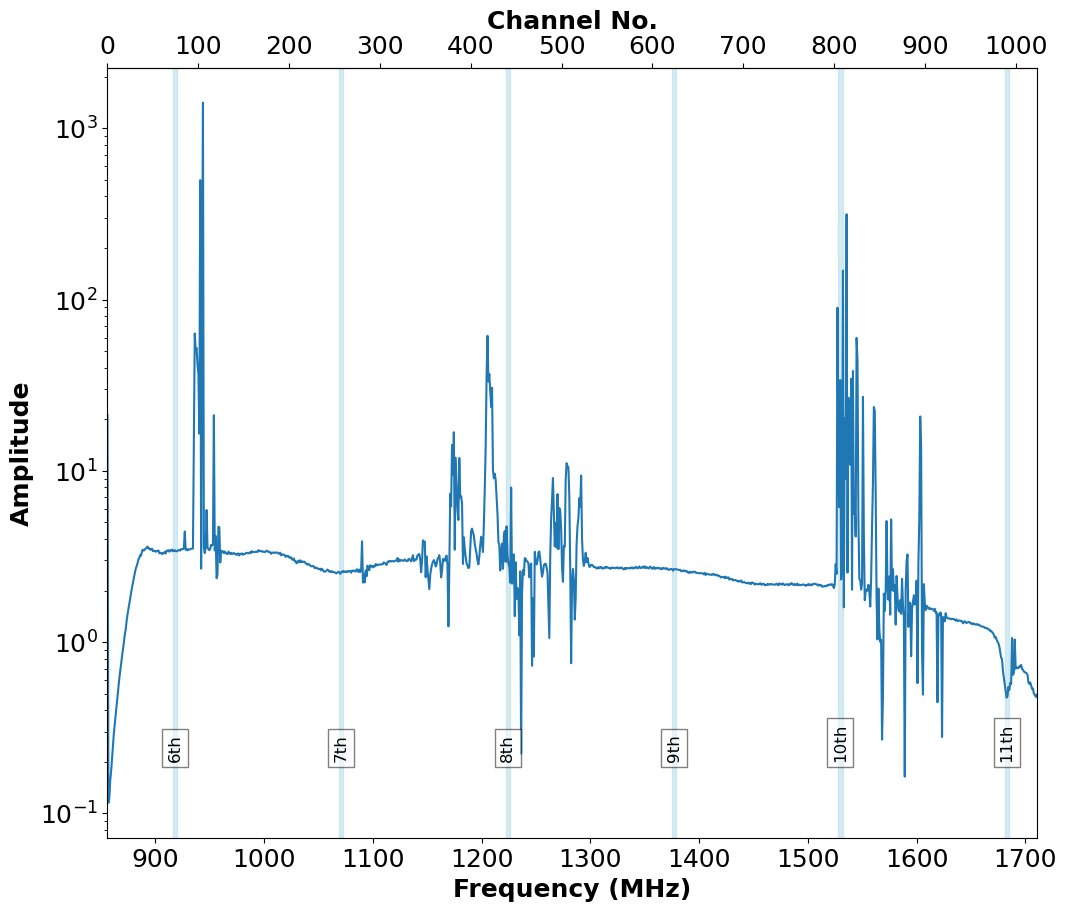

In [24]:
RFI_regions = [
    (916, 920, '6th'),  # (start, end, label)
    (1069, 1073, '7th'),
    (1222, 1226, '8th'),
    (1375, 1379, '9th'),
    (1528, 1532, '10th'),
    (1681, 1685, '11th'),

]

fig2, ax2 = plt.subplots(1,1)

ax2.plot(frequencies/1e6, np.abs(subset))
ax2.semilogy()
ax2.set_xlim(frequencies[0]/1e6, frequencies[-1]/1e6)

# Highlight the specified regions
for start, end, label in RFI_regions:
    ax2.axvspan(start, end, color='lightblue', alpha=0.5)
    ax2.text((start + end) / 2, 0.2, label, 
             horizontalalignment='center', verticalalignment='bottom', rotation='vertical',
             fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Frequency (MHz)')

secax_2 = ax2.secondary_xaxis('top', functions=(freq_to_channel, channel_to_freq))
secax_2.set_xticks(np.arange(0, 1024, 100))  # Ticks from 0 to 1024 in steps of 100
secax_2.set_xlabel('Channel No.')
plt.show()

# Calculating data for all antennae combinations

Has a runtime of around 10 min on the slow NASSP laptop. 

In [ ]:
vis_clean, vis_rfi = [], []
for a_1 in range(50): 
    print(a_1)
    for a_2 in range(a_1+1, 51):
        print(f'\t {a_2}') # shows progress
        idx = np.where((ds[0].ANTENNA1 == a_1) & (ds[0].ANTENNA2 == a_2))[0]
        vis_clean.append(np.abs(ds[0].DATA.data[idx][:,750, 0].compute()))
        vis_rfi.append(np.abs(ds[0].DATA.data[idx][:,420, 0].compute()))
combined_array_clean = np.concatenate(vis_clean)
combined_array_rfi = np.concatenate(vis_rfi)

# Histogram for clean region

In [ ]:
plt.hist(combined_array_clean, bins=500, density=True,alpha=0.5, lw=2)
plt.xlim([0.5, 3.5])
plt.ylim([0, 2.5])
plt.xlabel('Amplitude')
plt.ylabel('Normalized count')

# Histogram for RFI region

In [ ]:
plt.hist(combined_array_rfi, bins=500, density=True,alpha=0.5, lw=2)
plt.xlim([0.001, 70])
plt.xlabel('Amplitude')
plt.ylabel('Normalized count')

# Combined Histogram for comparison

In [ ]:
rw = 1
plt.hist(combined_array_clean, bins=500, density=True,alpha=1, rwidth=rw, label='Clean region', histtype='bar', color='r')
plt.hist(combined_array_rfi, bins=500, density=True,alpha=0.8, label='RFI region', rwidth=rw, histtype='bar', color='b')
plt.legend()
plt.xlabel('Amplitude')
plt.ylabel('Normalized count')
plt.xlim([0.1, 10])
plt.ylim([0, 2.15])

# Calculate index of shortest and longest baselines

In [ ]:
max_d, min_d = 0, float('inf')  # use infinity for max comparison
min_ant1, min_ant2, max_ant1, max_ant2 = 0, 0, 0, 0
antenna = antenna_table[0]['POSITION'].values
for a1 in range(len(antenna)):
    for a2 in range(a1 + 1, len(antenna)):
        # Calculate the distance efficiently
        dis = np.sqrt((antenna[a1][0] - antenna[a2][0])**2 + (antenna[a1][1] - antenna[a2][1])**2 + (antenna[a1][2] - antenna[a2][2])**2)
        
        # Check for min and max distance
        if dis < min_d:
            min_d = dis
            min_ant1, min_ant2 = a1, a2
        elif dis > max_d:
            max_d = dis
            max_ant1, max_ant2 = a1, a2

print(f'Max distance: {round(max_d, 2)} m from {antenna_table[0]['NAME'][max_ant1].values} (index = {max_ant1}) to {antenna_table[0]['NAME'][max_ant2].values} (index = {max_ant2})')
print(f'Min distance: {round(min_d, 2)} m from {antenna_table[0]['NAME'][min_ant1].values} (index = {min_ant1}) to {antenna_table[0]['NAME'][min_ant2].values} (index = {min_ant2})')

# Plotting Visiility for shortest baseline in RFI region

In [ ]:
a1, a2 = min_ant1, min_ant2
idx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]
antenna_table[0].NAME.data[a1].compute() , antenna_table[0].NAME.data[a2].compute()
data = ds[0].DATA.data[idx]
plt.imshow(np.abs(data[:,400:440,0]).T, 
           aspect= 'auto', 
           origin='lower', 
           cmap='PuRd', 
           norm = colors.LogNorm(vmax=1e2)
           )
plt.ylabel('Channel No')
plt.xlabel('Time')
yticks = np.arange(0, 40, 5)
yticks_labels = np.arange(400, 440, 5)
plt.yticks(yticks, labels=yticks_labels)
plt.colorbar()

# Plotting visibility for longest baseline in RFI region

In [ ]:
a1, a2 = max_ant1, max_ant2
idx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]
antenna_table[0].NAME.data[a1].compute() , antenna_table[0].NAME.data[a2].compute()
data = ds[0].DATA.data[idx]
plt.imshow(np.abs(data[:,400:440,0]).T, 
           aspect= 'auto', 
           origin='lower', 
           cmap='PuRd', 
           norm = colors.LogNorm(vmax=1e2)
           )
plt.ylabel('Channel No')
plt.xlabel('Time')
yticks = np.arange(0, 40, 5)
yticks_labels = np.arange(400, 440, 5)
plt.yticks(yticks, labels=yticks_labels)
plt.colorbar()

# Search for harmonics

In [ ]:
def find_closest(array, value):
    """
    Helper function to find index of closest value in array. Used here to convert from channel to frequency 
    :param array: np.ndarray to be searched for closest value
    :param value: float value to be searched for in array
    :return: int  index of closest value in array
    """
    diff = np.abs(array - value)
    idx = np.argmin(diff)
    return idx

In [ ]:
# a1, a2 = max_ant1, max_ant2 # or any desired antenna pair
a1, a2 = min_ant1, min_ant2
idx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]
data = ds[0].DATA.data[idx]

freqs = np.ravel(frequencies) * 1e-6
amp = np.abs(data[0, :, 0].compute())

harmonic_freqs = [918, 1071, 1224, 1377, 1530, 1683]

for f in harmonic_freqs:
    f_lower, f_upper = f-100, f+100
    f_lower_idx = find_closest(freqs, f_lower)
    f_upper_idx = find_closest(freqs, f_upper)
    plt.plot(freqs[f_lower_idx: f_upper_idx], amp[f_lower_idx: f_upper_idx], 'b')
    plt.ylabel('Amplitude')
    plt.xlabel('frequency (MHz)')
    plt.axvline(x=freqs[find_closest(freqs, f)], color='r', linestyle='--', label=f'Expected harmonic at {f} MHz')
    plt.legend()
    plt.show()

# Filtering attempt

Shortest baseline


In [ ]:
a1, a2 = min_ant1, min_ant2
idx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]
data = ds[0].DATA.data[idx]

freqs = np.ravel(frequencies) * 1e-6
amp = np.abs(data[0, :, 0].compute())

new_amp, new_freq = np.copy(amp), np.copy(freqs)
print(np.std(new_amp))
cuttoff = 4
print(cuttoff)
for i, a in enumerate(new_amp):
    if a >= cuttoff:
        new_amp[i] = np.nan
        
plt.plot(freqs, amp, 'b', label='Before')
plt.plot(new_freq, new_amp, 'r', label='After')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')

Longest baseline

In [ ]:
a1, a2 = max_ant1, max_ant2
idx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]
data = ds[0].DATA.data[idx]

freqs = np.ravel(frequencies) * 1e-6
amp = np.abs(data[0, :, 0].compute())

new_amp, new_freq = np.copy(amp), np.copy(freqs)
print(np.std(new_amp))
cuttoff = 4
print(cuttoff)
for i, a in enumerate(new_amp):
    if a >= cuttoff:
        new_amp[i] = np.nan
        
plt.plot(freqs, amp, 'b', label='Before')
plt.plot(new_freq, new_amp, 'r', label='After')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')

# Detrending

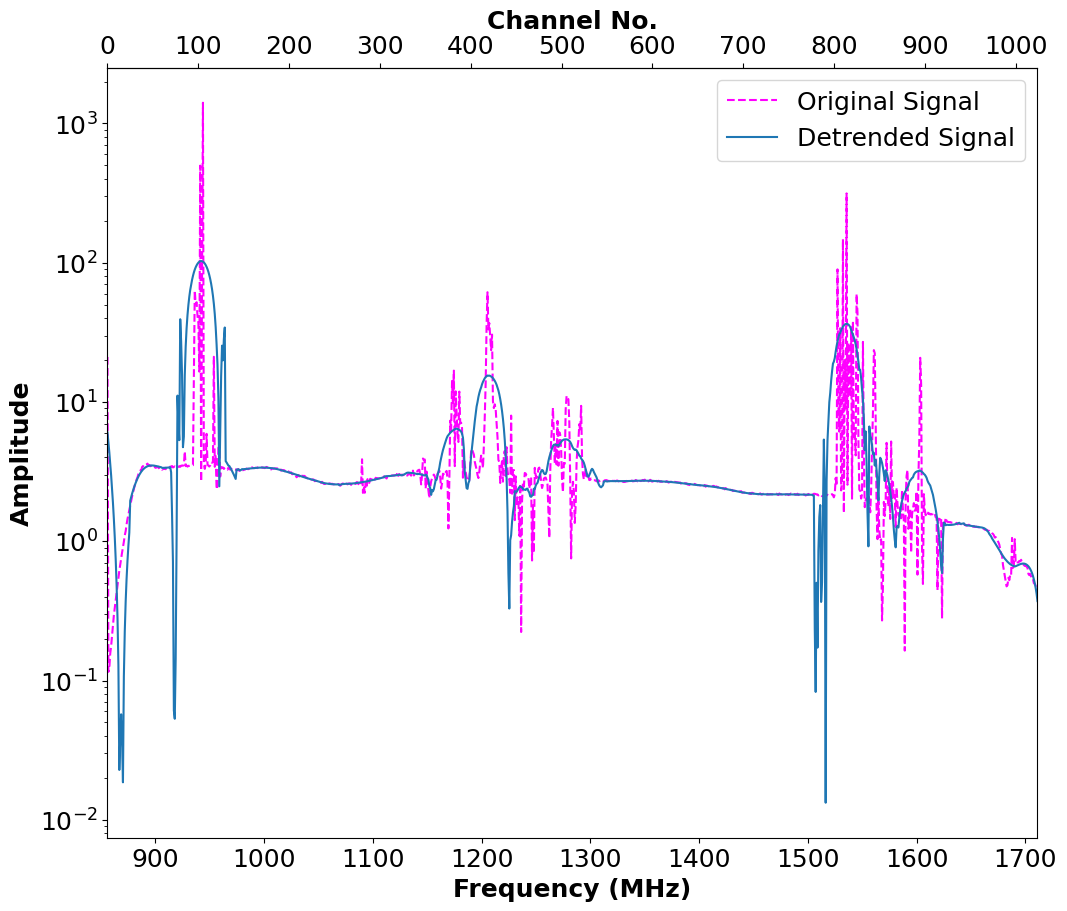

In [29]:
detrended_subset = signal.savgol_filter(np.abs(subset), window_length=50, polyorder=3)
fig3, ax3 = plt.subplots(1,1)

ax3.plot(frequencies/1e6, np.abs(subset), color='magenta', ls='--', label = 'Original Signal')
ax3.plot(frequencies/1e6, np.abs(detrended_subset), label='Detrended Signal')
ax3.semilogy()
ax3.set_xlim(frequencies[0]/1e6, frequencies[-1]/1e6)
ax3.set_ylabel('Amplitude')
ax3.set_xlabel('Frequency (MHz)')

secax_3 = ax3.secondary_xaxis('top', functions=(freq_to_channel, channel_to_freq))
secax_3.set_xticks(np.arange(0, 1024, 100))  # Ticks from 0 to 1024 in steps of 100
secax_3.set_xlabel('Channel No.')
plt.legend()
plt.show()

In [30]:
print(np.var(np.abs(subset)))
print('XXXXXXXXXXXX')
print(np.var(detrended_subset))

<xarray.DataArray 'DATA' ()> Size: 8B
array(2321.85864258)
Coordinates:
    ROWID    int64 8B 500
XXXXXXXXXXXX
224.43637


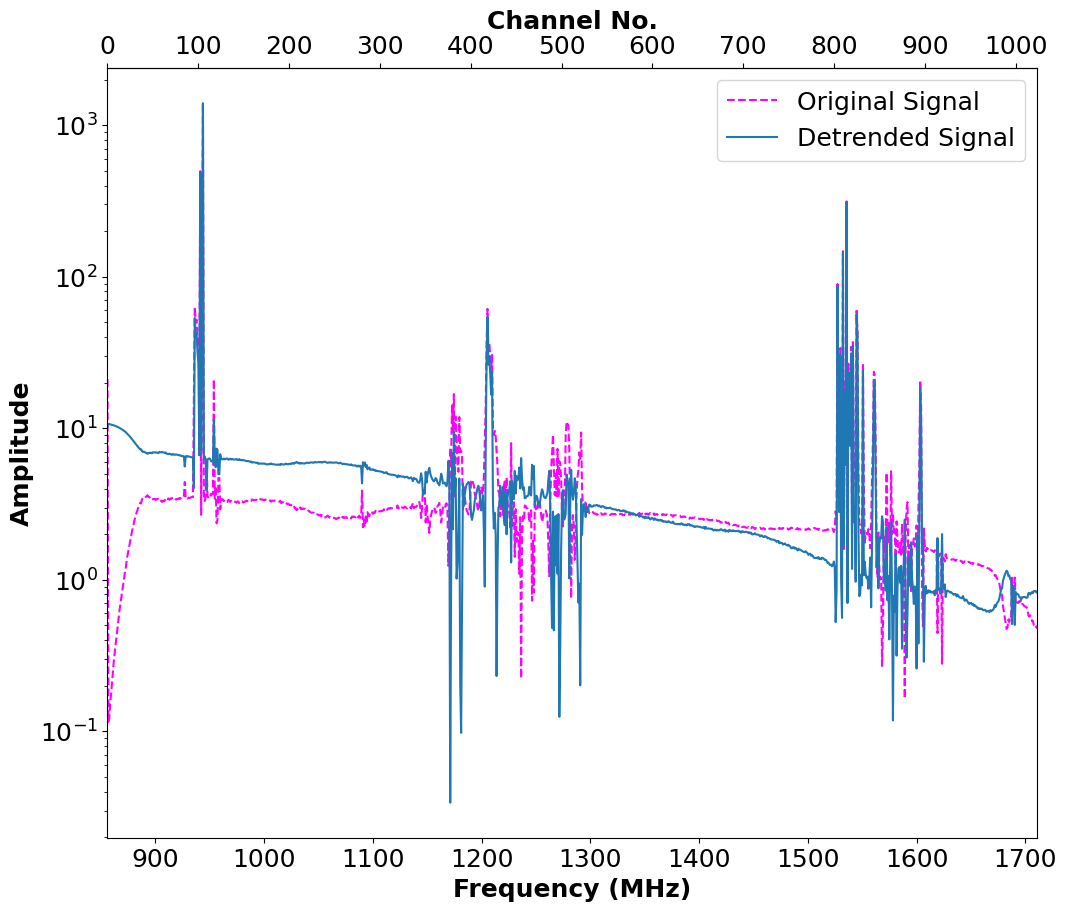

In [31]:
detrended_subset = signal.detrend(np.abs(subset), type='linear')
fig4, ax4 = plt.subplots(1,1)

ax4.plot(frequencies/1e6, np.abs(subset), color='magenta', ls='--', label = 'Original Signal')
ax4.plot(frequencies/1e6, np.abs(detrended_subset), label='Detrended Signal')
ax4.semilogy()
ax4.set_xlim(frequencies[0]/1e6, frequencies[-1]/1e6)
ax4.set_ylabel('Amplitude')
ax4.set_xlabel('Frequency (MHz)')

secax_4 = ax4.secondary_xaxis('top', functions=(freq_to_channel, channel_to_freq))
secax_4.set_xticks(np.arange(0, 1024, 100))  # Ticks from 0 to 1024 in steps of 100
secax_4.set_xlabel('Channel No.')
plt.legend()
plt.show()

In [32]:
print(np.var(np.abs(subset)))
print('XXXXXXXXXXXX')
print(np.var(detrended_subset))

<xarray.DataArray 'DATA' ()> Size: 8B
array(2321.85864258)
Coordinates:
    ROWID    int64 8B 500
XXXXXXXXXXXX
2314.3198


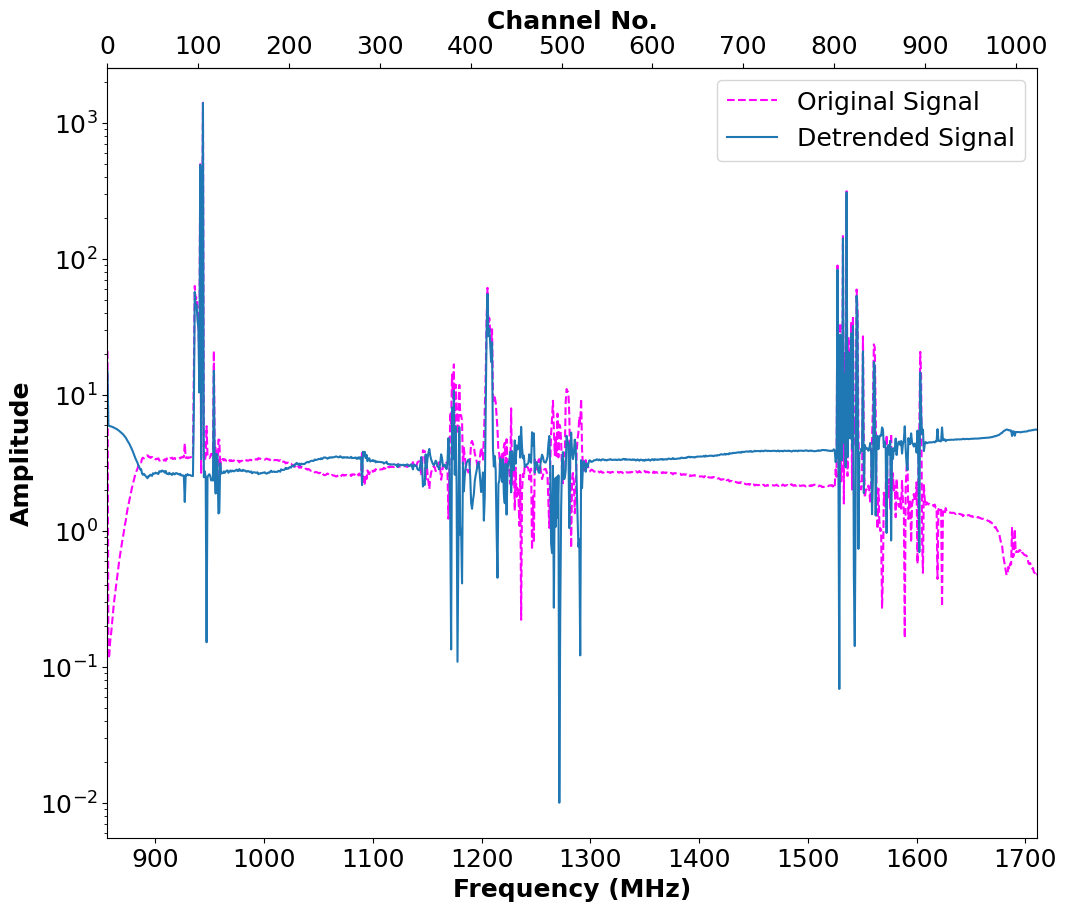

In [33]:
detrended_subset = signal.detrend(np.abs(subset), type='constant')
fig5, ax5 = plt.subplots(1,1)

ax5.plot(frequencies/1e6, np.abs(subset), color='magenta', ls='--', label = 'Original Signal')
ax5.plot(frequencies/1e6, np.abs(detrended_subset), label='Detrended Signal')
ax5.semilogy()
ax5.set_xlim(frequencies[0]/1e6, frequencies[-1]/1e6)
ax5.set_ylabel('Amplitude')
ax5.set_xlabel('Frequency (MHz)')

secax_5 = ax5.secondary_xaxis('top', functions=(freq_to_channel, channel_to_freq))
secax_5.set_xticks(np.arange(0, 1024, 100))  # Ticks from 0 to 1024 in steps of 100
secax_5.set_xlabel('Channel No.')
plt.legend()
plt.show()

In [34]:
print(np.var(np.abs(subset)))
print('XXXXXXXXXXXX')
print(np.var(detrended_subset))

<xarray.DataArray 'DATA' ()> Size: 8B
array(2321.85864258)
Coordinates:
    ROWID    int64 8B 500
XXXXXXXXXXXX
2321.8599


# Satellites

In [37]:
# Set the observer's location (MeerKAT)
observer = ephem.Observer()
observer.lat = '37.7749'  # Latitude in degrees
observer.lon = '-122.4194'  # Longitude in degrees
observer.elevation = 1087  # Elevation in meters
observer.date = '2019/1/31 12:57:00'  # Observation date and time

# List to store visible satellites
visible_satellites = []

tle_file = 'requested_TLE.txt'

with open(tle_file, 'r') as file:
    lines = file.readlines()

# Process TLE data
for i in range(0, len(lines), 3):
    name = lines[i].strip()  # Satellite name
    line1 = lines[i + 1].strip()  # First line of TLE
    line2 = lines[i + 2].strip()  # Second line of TLE

    # Create satellite object
    satellite = ephem.readtle(name, line1, line2)
        
    # Compute the satellite's position
    satellite.compute(observer)

    # Check if the satellite is above the horizon (altitude > 0)
    if satellite.alt > 0:
        visible_satellites.append((name, satellite.alt, satellite.az, satellite.ra, satellite.dec))

print(len(visible_satellites))

# Print visible satellites
for name, alt, az, ra, dec in visible_satellites:
    print(f"Satellite: {name}, Altitude: {alt}, Azimuth: {az}, RA: {ra}, Dec: {dec}")

80
Satellite: GSAT0204 (GALILEO 8), Altitude: 35:07:11.2, Azimuth: 315:01:34.1, RA: 8:08:21.98, Dec: 54:04:00.1
Satellite: GSAT0204 (GALILEO 8), Altitude: 35:07:00.9, Azimuth: 315:01:41.9, RA: 8:08:20.64, Dec: 54:04:03.0
Satellite: GSAT0204 (GALILEO 8), Altitude: 35:06:56.2, Azimuth: 315:01:44.0, RA: 8:08:20.08, Dec: 54:04:03.3
Satellite: BEIDOU-2 M6, Altitude: 78:16:39.2, Azimuth: 357:11:36.4, RA: 13:25:38.67, Dec: 49:29:01.1
Satellite: BEIDOU-2 M6, Altitude: 78:16:39.8, Azimuth: 357:10:15.0, RA: 13:25:36.98, Dec: 49:28:59.6
Satellite: BEIDOU-2 M6, Altitude: 78:16:31.8, Azimuth: 357:12:03.4, RA: 13:25:39.19, Dec: 49:29:08.8
Satellite: BEIDOU-2 M6, Altitude: 78:16:30.4, Azimuth: 357:11:55.0, RA: 13:25:39.01, Dec: 49:29:10.1
Satellite: BEIDOU-2 M6, Altitude: 78:16:23.3, Azimuth: 357:12:12.6, RA: 13:25:39.33, Dec: 49:29:17.4
Satellite: BEIDOU-3S M2S, Altitude: 69:37:00.4, Azimuth: 274:00:23.6, RA: 11:46:49.83, Dec: 36:24:01.2
Satellite: BEIDOU-3S M2S, Altitude: 69:36:51.9, Azimuth: 274:0

In [38]:
source_ra = math.radians(5.1462)
source_dec = math.radians(-1.1120)
print(f'Source RA: {source_ra:.4f}, Dec: {source_dec:.4f}')

def angular_distance(ra1, dec1, ra2, dec2):
    # Calculate the differences
    delta_ra = ra2 - ra1
    delta_dec = dec2 - dec1

    # Haversine formula
    distance = 2 * np.arcsin(np.sqrt(np.sin(delta_dec / 2)**2 + 
                     np.cos(dec1) * np.cos(dec2) * np.sin(delta_ra / 2)**2))
    
    return distance  # Distance in radians

# List to store satellites within the beam
sat_dist = []
# Process each visible satellite
for sat in visible_satellites:
    distance = angular_distance(source_ra, source_dec, sat[3], sat[4])
    sat_dist.append(distance)
    print(f"Satellite {sat[0]}: Altitude: {sat[1]}, Azimuth: {sat[2]}, Angular Separation: {distance} rad")
sat_dist = np.array(sat_dist)
visible_satellites = np.array(visible_satellites)
final_sat = np.column_stack((visible_satellites,sat_dist))
print(final_sat.shape)

Source RA: 0.0898, Dec: -0.0194
Satellite GSAT0204 (GALILEO 8): Altitude: 35:07:11.2, Azimuth: 315:01:34.1, Angular Separation: 1.8562429947947459 rad
Satellite GSAT0204 (GALILEO 8): Altitude: 35:07:00.9, Azimuth: 315:01:41.9, Angular Separation: 1.85618483443493 rad
Satellite GSAT0204 (GALILEO 8): Altitude: 35:06:56.2, Azimuth: 315:01:44.0, Angular Separation: 1.856161998799293 rad
Satellite BEIDOU-2 M6: Altitude: 78:16:39.2, Azimuth: 357:11:36.4, Angular Separation: 2.263083740024511 rad
Satellite BEIDOU-2 M6: Altitude: 78:16:39.8, Azimuth: 357:10:15.0, Angular Separation: 2.263119619520371 rad
Satellite BEIDOU-2 M6: Altitude: 78:16:31.8, Azimuth: 357:12:03.4, Angular Separation: 2.263039804465663 rad
Satellite BEIDOU-2 M6: Altitude: 78:16:30.4, Azimuth: 357:11:55.0, Angular Separation: 2.263037293724988 rad
Satellite BEIDOU-2 M6: Altitude: 78:16:23.3, Azimuth: 357:12:12.6, Angular Separation: 2.2629987994597234 rad
Satellite BEIDOU-3S M2S: Altitude: 69:37:00.4, Azimuth: 274:00:23.6,

In [39]:
# Function to split the array by the first column (satellite names)
def split_by_satellite(data):
    # Get unique satellite names from the first column
    satellite_names = np.unique(data[:, 0])

    # List to store arrays
    satellite_arrays = []

    # Create separate arrays for each satellite
    for name in satellite_names:
        # Extract the rows corresponding to the current satellite
        satellite_array = data[data[:, 0] == name]
        
        # Append the satellite array to the list
        satellite_arrays.append(satellite_array)

        # For demonstration, print the satellite name and its shape
        print(f"{name.replace(' ', '_')} shape: {satellite_array.shape}")

    return satellite_arrays

# Call the function and store the resulting list
satellite_arrays = split_by_satellite(final_sat)

BEIDOU-2_G4 shape: (5, 6)
BEIDOU-2_M3 shape: (3, 6)
BEIDOU-2_M6 shape: (5, 6)
BEIDOU-3_M12 shape: (4, 6)
BEIDOU-3_M14 shape: (5, 6)
BEIDOU-3_M15 shape: (5, 6)
BEIDOU-3_M3 shape: (3, 6)
BEIDOU-3_M8 shape: (6, 6)
BEIDOU-3S_M2S shape: (5, 6)
COSMOS_2432_[GLONASS-M] shape: (3, 6)
COSMOS_2433_[GLONASS-M] shape: (4, 6)
COSMOS_2436_[GLONASS-M] shape: (3, 6)
COSMOS_2476_[GLONASS-M] shape: (5, 6)
COSMOS_2492_[GLONASS-M] shape: (5, 6)
COSMOS_2527_[GLONASS-M] shape: (6, 6)
GSAT0101_(GALILEO-PFM) shape: (2, 6)
GSAT0204_(GALILEO_8) shape: (3, 6)
GSAT0212_(GALILEO_16) shape: (2, 6)
GSAT0213_(GALILEO_17) shape: (4, 6)
GSAT0214_(GALILEO_18) shape: (2, 6)


In [40]:
for sat in satellite_arrays:
    print(sat[0,0])
    #print(sat[:,5].astype(float) * (180/np.pi))
    sat_mean_dist = np.mean(sat[:, 5].astype(float))
    print(sat_mean_dist*(180/np.pi))

BEIDOU-2 G4
112.54766553882484
BEIDOU-2 M3
159.94547954481652
BEIDOU-2 M6
129.66354908984266
BEIDOU-3 M12
90.7272159370849
BEIDOU-3 M14
148.43799546054424
BEIDOU-3 M15
147.85504438009394
BEIDOU-3 M3
83.85259366048705
BEIDOU-3 M8
98.42685226724477
BEIDOU-3S M2S
143.85403710169084
COSMOS 2432 [GLONASS-M]
87.23068602498418
COSMOS 2433 [GLONASS-M]
131.89848595394295
COSMOS 2436 [GLONASS-M]
50.057220499781025
COSMOS 2476 [GLONASS-M]
86.38883665593936
COSMOS 2492 [GLONASS-M]
139.39399910778724
COSMOS 2527 [GLONASS-M]
151.10069424000505
GSAT0101 (GALILEO-PFM)
125.0049386455467
GSAT0204 (GALILEO 8)
106.35223166184694
GSAT0212 (GALILEO 16)
128.3196902617672
GSAT0213 (GALILEO 17)
72.42315687899757
GSAT0214 (GALILEO 18)
173.73964771837583


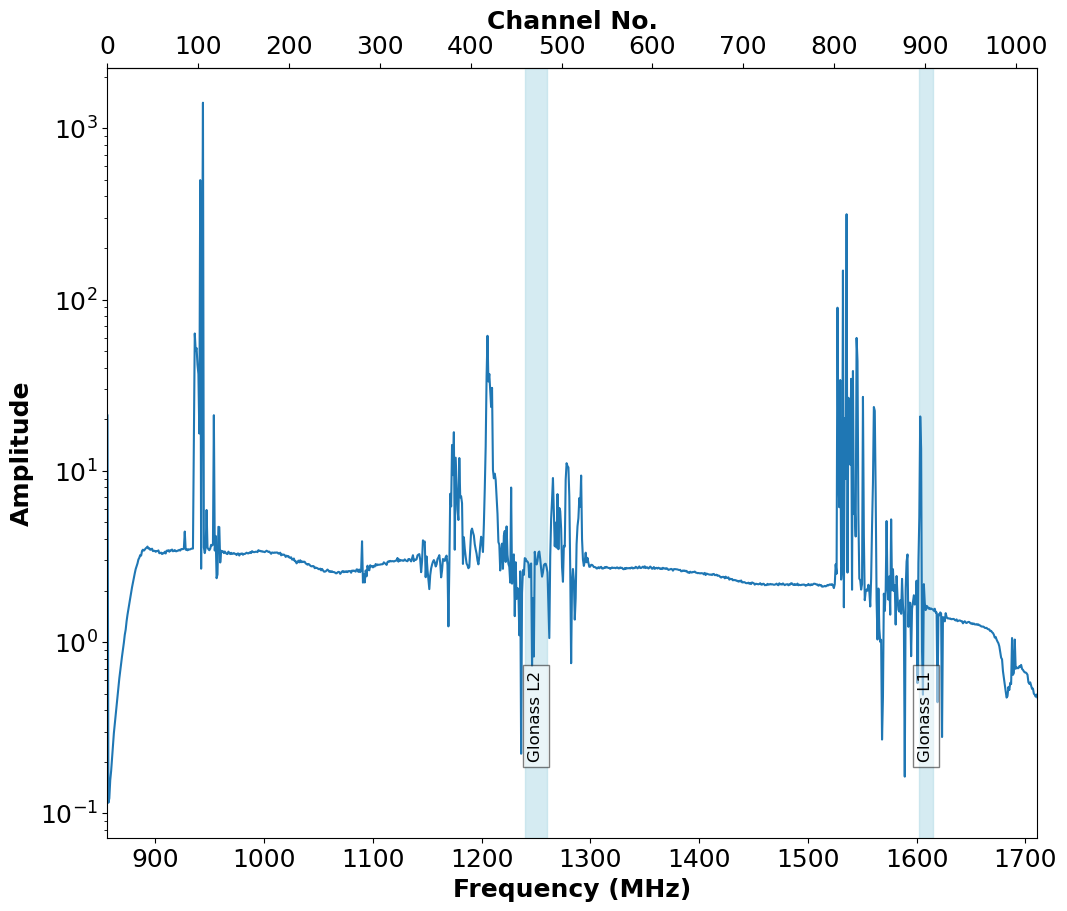

In [41]:
satellite_regions = [
    (1602, 1615, 'Glonass L1'),
    (1240, 1260, 'Glonass L2')
]

fig6, ax6 = plt.subplots(1,1)

ax6.plot(frequencies/1e6, np.abs(subset))
ax6.semilogy()
ax6.set_xlim(frequencies[0]/1e6, frequencies[-1]/1e6)

# Highlight the specified regions
for start, end, label in satellite_regions:
    ax6.axvspan(start, end, color='lightblue', alpha=0.5)
    ax6.text((start + end) / 2, 0.2, label, 
             horizontalalignment='center', verticalalignment='bottom', rotation='vertical',
             fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))

ax6.set_ylabel('Amplitude')
ax6.set_xlabel('Frequency (MHz)')

secax_6 = ax6.secondary_xaxis('top', functions=(freq_to_channel, channel_to_freq))
secax_6.set_xticks(np.arange(0, 1024, 100))  # Ticks from 0 to 1024 in steps of 100
secax_6.set_xlabel('Channel No.')
plt.show()